<a href="https://colab.research.google.com/github/monicafar147/To-vaccinate-or-not-/blob/data-distributions/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the past decade, tracking health trends using social media data has shown great promise, due to:
-  a powerful combination of massive adoption of social media around the world
-  increasingly potent hardware and software that enables us to work with these new big data streams. 

At the same time, many challenging problems have been identified:
1. There is often a mismatch between how rapidly online data can change, and how rapidly algorithms are updated, which means that there is limited reusability for algorithms trained on past data as their performance decreases over time.
2. Much of the work is focusing on specific issues during a specific past period in time, even though public health institutions would need flexible tools to assess multiple evolving situations in real time. 
3. Most tools providing such capabilities are proprietary systems with little algorithmic or data transparency, and thus little buy-in from the global public health and research community. 

The objective of this challenge is to develop a machine learning model to assess if a twitter post that is related to vaccinations is
- positive
- neutral
- negative.

Tweets have been classified as
-  pro-vaccine (1)
-  neutral (0) 
-  anti-vaccine (-1). 
The tweets have had usernames and web addresses removed.

# Importing the data

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv("https://raw.githubusercontent.com/monicafar147/To-vaccinate-or-not-/master/Train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/monicafar147/To-vaccinate-or-not-/master/Test.csv")

Variable definition
- tweet_id: Unique identifier of the tweet
- safe_tweet: Text contained in the tweet. Some sensitive information has been removed like usernames and urls
- label: Sentiment of the tweet (-1 for negative, 0 for neutral, 1 for positive)
- agreement: The tweets were labeled by three people. Agreement indicates the percentage of the three reviewers that agreed on the given label. You may use this column in your training, but agreement data will not be shared for the test set.

In [2]:
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [4]:
# checking null values
unique = [row for row in train['safe_text'].unique()]
print("Number of unique values")
print(train['safe_text'].nunique())
print("\nTotal number of values")
print(len(train['tweet_id']))
print("\nNumber of null values:\n" + str(train.isnull().sum()))

Number of unique values
9658

Total number of values
10001

Number of null values:
tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64


- There is 1 label that contains a null value
- There are 2 agreements that contain a null value

In [5]:
#drop the nulls
train.dropna(inplace=True)
test.dropna(inplace=True)

In [6]:
#drop duplicate data
train.drop_duplicates(subset=None, keep='first', inplace=False)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.000000
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.000000
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.000000
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.000000
...,...,...,...,...
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.000000
9997,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.666667
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.000000
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000


In [7]:
# checking null values
unique = [row for row in train['safe_text'].unique()]
print("Number of unique values")
print(train['tweet_id'].nunique())
print("\nTotal number of values")
print(len(train['tweet_id']))
print("\nNumber of null values:\n" + str(train.isnull().sum()))

Number of unique values
9999

Total number of values
9999

Number of null values:
tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64


In [8]:
grouped = train[['label', 'safe_text',]].groupby('label').count()

In [9]:
grouped

,safe_text
label,
-1.0,1038
0.0,4908
1.0,4053


Looks a lot better!!!

In [10]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


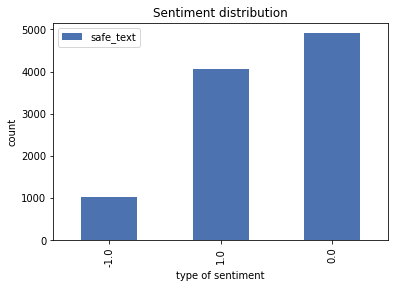

In [11]:
grouped.sort_values('safe_text', ascending=True).plot(kind='bar')
plt.title('Sentiment distribution')
plt.ylabel('count')
plt.xlabel('type of sentiment')
plt.show()

The data is unbalanced.

To counter this the following strategies can be used
- cross validation
- use small test size
- use stratify in train-test split
- use SMOTE
- up-sampling of data
- down-sampling of data


In [12]:
train['agreement'] = train['agreement'].round(2)

Text(0.5, 1.0, 'Distribution of agreement values')

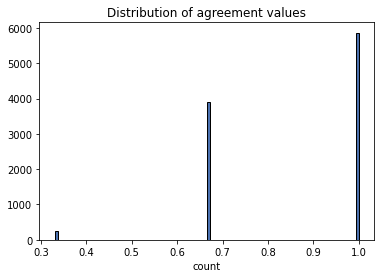

In [13]:
#looking at agreement column
plt.hist(train['agreement'], bins = 100, edgecolor = 'k')
plt.xlabel('count') 
plt.title('Distribution of agreement values')

In [14]:
agreed = train[['agreement', 'safe_text',]].groupby('agreement').count()
agreed

,safe_text
agreement,
0.33,239
0.67,3894
1.00,5866


To improve the model accuracy
- use agreement more than 0.3
- only use 100% agreement

In [19]:
# Dropping rows where agreement is not 0.67
data = train[train['agreement'] > 0.66]

In [20]:
data

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.00
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.00
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.00
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.00
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.00
...,...,...,...,...
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.00
9997,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.67
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.00
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.00


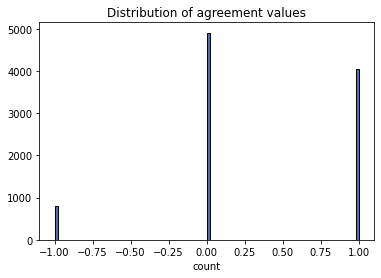

In [21]:
#looking at agreement column
plt.hist(data['label'], bins = 100, edgecolor = 'k')
plt.xlabel('count') 
plt.title('Distribution of agreement values')
plt.show()

The data is still very imbalanced

# EDA

In [22]:
from nltk.tokenize import TweetTokenizer

In [23]:

def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [24]:
tokeniser = TweetTokenizer()
data['tokens'] = data['safe_text'].apply(tokeniser.tokenize)
sentiment_labels = list(set(data['label'].values))
sentiment = {}
for sent in sentiment_labels:
    df = data.groupby('label')
    sentiment[sent] = {}
    for row in df.get_group(sent)['tokens']:
        sentiment[sent] = bag_of_words_count(row, sentiment[sent])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
anti = {key: value for key, value in sorted(sentiment[-1].items(), key=lambda item: item[1], reverse=True)}
neutral = {key: value for key, value in sorted(sentiment[0].items(), key=lambda item: item[1], reverse=True)}
pro = {key: value for key, value in sorted(sentiment[1].items(), key=lambda item: item[1], reverse=True)}

In [26]:
from string import punctuation
import nltk
nltk.download(['stopwords','punkt'])
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
random = set(stopwords.words('english') + list(punctuation)+["<user>","<url>"])

In [29]:
# anti
anti_keys = [key for key in anti.keys() if key not in random]
anti_values = [value[1] for value in anti.items() if value[0] not in random]
# neutral
neutral_keys = [key for key in neutral.keys() if key not in random]
neutral_values = [value[1] for value in neutral.items() if value[0] not in random]
# pro
pro_keys = [key for key in pro.keys() if key not in random]
pro_values = [value[1] for value in pro.items() if value[0] not in random]


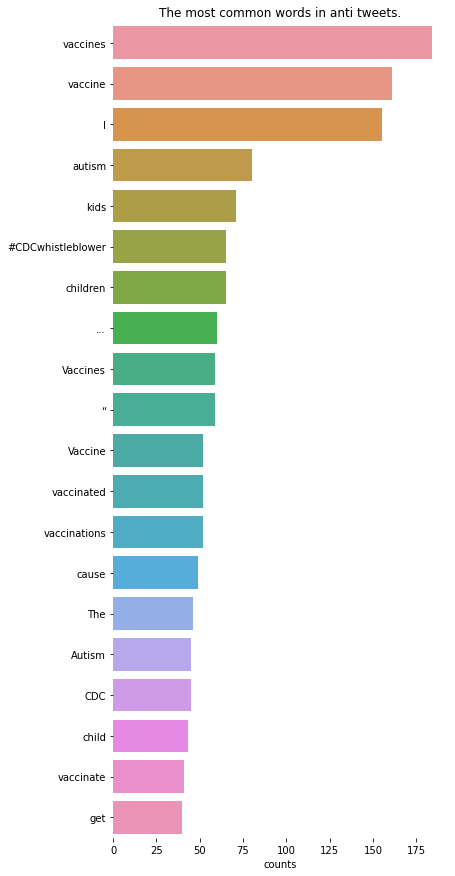

In [30]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(anti_values[0:20],anti_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in anti tweets.')
sns.despine(left=True, bottom=True)

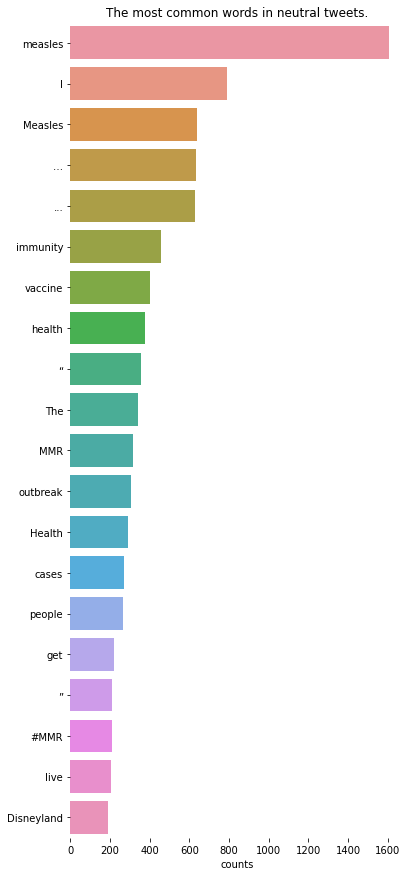

In [31]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(neutral_values[0:20],neutral_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in neutral tweets.')
sns.despine(left=True, bottom=True)

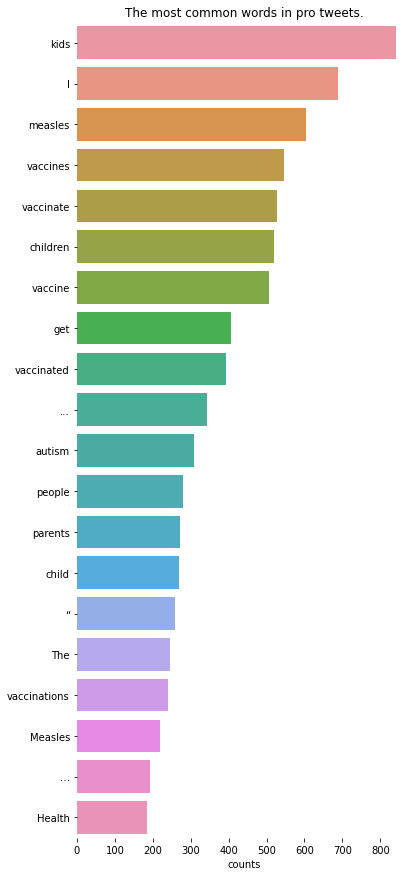

In [32]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(pro_values[0:20],pro_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in pro tweets.')
sns.despine(left=True, bottom=True)

Look into the words user and URL

In [33]:
anti_tweets = data['safe_text'][data['label']==-1]
neutral_tweets = data['safe_text'][data['label']==0]
pro_tweets = data['safe_text'][data['label']==1]

In [34]:
anti_hashtags = anti_tweets.str.extractall(r'(\#\w+)')[0].value_counts()
neutral_hashtags = neutral_tweets.str.extractall(r'(\#\w+)')[0].value_counts()
pro_hashtags = pro_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

In [35]:
print("\033[1mAnti hastags\033[0m\n" + str(anti_hashtags))

Anti hastags
#CDCwhistleblower               65
#autism                         20
#vaccines                       19
#vaccine                        16
#VaxTruth                       10
                                ..
#GuillamBared                    1
#fearmongers                     1
#healthfreedom                   1
#pediatrics                      1
#ConfessYourUnpopularOpinion     1
Name: 0, Length: 233, dtype: int64


In [36]:
print("\033[1mNeutral hastags\033[0m\n" + str(neutral_hashtags))

Neutral hastags
#MMR                 210
#measles             162
#mmr                 140
#Ebola                53
#dc                   48
                    ... 
#patriotism            1
#peg                   1
#thingsoverheard       1
#greens                1
#sightbeyondsight      1
Name: 0, Length: 1533, dtype: int64


In [37]:
print("\033[1mPro hastags\033[0m\n" + str(pro_hashtags))

Pro hastags
#vaccineswork        118
#measles             101
#vaccines             50
#vaccine              45
#vaccinate            42
                    ... 
#hateantivaxxers       1
#AspenIdeas            1
#Dogtism               1
#onetime               1
#ColorMeImpressed      1
Name: 0, Length: 941, dtype: int64


In [38]:
eda = pd.DataFrame()
eda['pro_hashtags'] = list(pro_hashtags.index)[0:20]
eda['pro_counts'] = list(pro_hashtags.values)[0:20]
eda['neutral_hashtags'] = list(neutral_hashtags.index)[0:20]
eda['neutral_counts'] = list(neutral_hashtags.values)[0:20]
eda['anti_hashtags'] = list(anti_hashtags.index)[0:20]
eda['anti_counts'] = list(anti_hashtags.values)[0:20]


In [39]:
eda.head()

,pro_hashtags,pro_counts,neutral_hashtags,neutral_counts,anti_hashtags,anti_counts
0,#vaccineswork,118,#MMR,210,#CDCwhistleblower,65
1,#measles,101,#measles,162,#autism,20
2,#vaccines,50,#mmr,140,#vaccines,19
3,#vaccine,45,#Ebola,53,#vaccine,16
4,#vaccinate,42,#dc,48,#VaxTruth,10


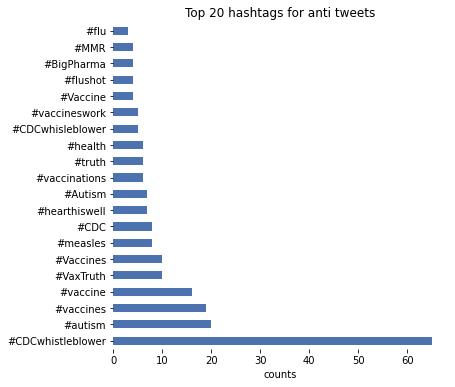

In [40]:
#plot these findings
f, ax = plt.subplots(figsize=(6, 6))
anti_hashtags[0:20].plot(kind='barh')
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('Top 20 hashtags for anti tweets')
sns.despine(left=True, bottom=True)
plt.show()


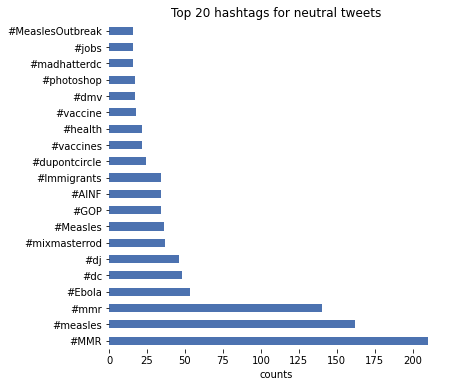

In [41]:
#plot these findings
f, ax = plt.subplots(figsize=(6, 6))
neutral_hashtags[0:20].plot(kind='barh')
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('Top 20 hashtags for neutral tweets')
sns.despine(left=True, bottom=True)
plt.show()

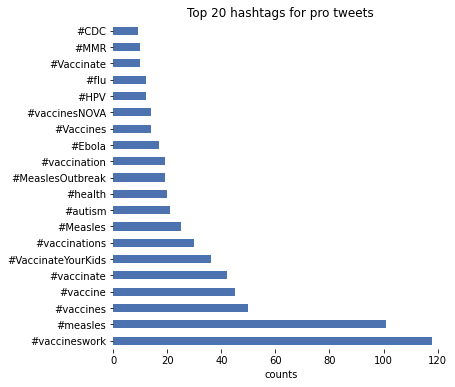

In [42]:
#plot these findings
f, ax = plt.subplots(figsize=(6, 6))
pro_hashtags[0:20].plot(kind='barh')
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('Top 20 hashtags for pro tweets')
sns.despine(left=True, bottom=True)
plt.show()

#Text cleaning

How many times do retweets occur?

In [43]:
#how many times does retweet occur?
rts = [0]
op =[]
for i in data['safe_text']:
  if 'RT' in i:
    rts.append(i)
  else:
    op.append(i)

print("Number of Original Tweets: " + str(len(op)))
print("\nNumber of Retweets: " + str(len(rts)))
print("\nRatio of Orignal Tweets to retweets: " + str(round(len(rts)/len(op),2)))

Number of Original Tweets: 9458

Number of Retweets: 303

Ratio of Orignal Tweets to retweets: 0.03


Even though the retweet ratio is really small, it is best to drop the retweets do have more balanced data

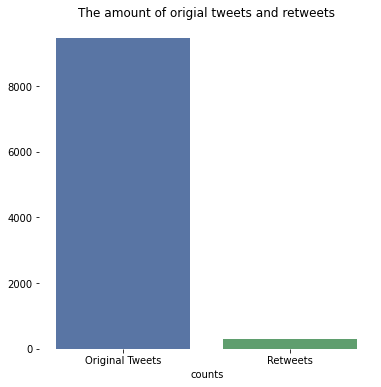

In [44]:
lengths = [len(op),len(rts)]
values = ['Original Tweets', 'Retweets']
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(values,lengths)
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The amount of origial tweets and retweets')
sns.despine(left=True, bottom=True)
plt.show()

lets look at a tweet and the features of a tweet:
- Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>
- I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day
- Measles in the 717 😳😳😳😳😳😷😷😷

1. lowercase the words
2. remove # but keep the word
3. remove @ but keep the word
4. remove punctuation
5. keep emojis


In [39]:
import re

In [45]:
def clean_tweets(tweet):
  '''takes string as input and returns a string that has been cleaned'''
  tweet = tweet.lower()
  #tweet = tweet.replace('<url>',"")
  #tweet = tweet.replace('<user>',"")
  #tokenizer = TweetTokenizer(reduce_len=True)
  #tokens = tokenizer.tokenize(tweet)
  #garbage = set(stopwords.words('english') + list(punctuation))
  #tweet = [word for word in tokens if word not in garbage]
  #tweet = re.sub(r'#([^\s]+)', r'\1', " ".join(tweet))
  #tweet = re.sub(r'@([^\s]+)', r'\1', "".join(tweet)) 
  return tweet  

In [46]:
tweet = 'Me &amp; !!!! 😳 The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St.... <url> <user>'

In [47]:
print(clean_tweets(tweet))

me &amp; !!!! 😳 the big homie meanboy3000 #meanboy #mb #mbs #mmr #stegmanlife @ stegman st.... <url> <user>


In [48]:
#apply cleaning process to train and test data
data['cleaned'] = data['safe_text'].apply(clean_tweets)
test['cleaned'] = test['safe_text'].apply(clean_tweets)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Modelling

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X = data['cleaned'].values
y = data['label'].values

In [51]:
# Splitting the labels and fetures into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02,random_state=42,stratify=y)

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [53]:
#creating a pipeline with the tfid vectorizer and a linear svc model
svc = Pipeline([('tfidf',TfidfVectorizer()),('classify',LinearSVC(C=1))])

#fitting the model
svc.fit(X_train, y_train)

#apply model on test data
y_pred_svc = svc.predict(X_test)

In [54]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
RMSE = mean_squared_error(y_test, y_pred_svc)**0.5

In [55]:
print(RMSE)

0.6813851438692469


In [56]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

        -1.0       0.50      0.19      0.27        16
         0.0       0.79      0.82      0.81        99
         1.0       0.68      0.74      0.71        81

    accuracy                           0.73       196
   macro avg       0.66      0.58      0.60       196
weighted avg       0.72      0.73      0.72       196



In [57]:
#use predictproba
from sklearn.linear_model import LogisticRegression
#clf = Pipeline([('tfidf',TfidfVectorizer()),('classify',LogisticRegression(solver='liblinear', penalty='l1', C=0.1, class_weight='balanced'))])

#creating a pipeline with a tfidf vectorizer and a logistic regression model
LR_model = Pipeline([('tfidf',TfidfVectorizer()),('classify',(LogisticRegression(C=1.0,solver='lbfgs',random_state=42,max_iter=200, class_weight='balanced')))])

#fitting the model
LR_model.fit(X_train, y_train)

#Apply model on test data
y_pred_lr = LR_model.predict(X_test)

In [58]:
y_pred = LR_model.predict_proba(X_test)

In [59]:
predictions = []
for row in y_pred:
  maximum = np.max(row)
  if maximum == row[0]: #if anti
    maximum = maximum*-1
  if maximum == row[1]: #if neutral
    maximum = 0
  predictions.append(maximum)

In [ ]:
predictions

In [61]:
# Linear SVC
x_unseen = test['cleaned'].values
zindi_svc = svc.predict(x_unseen) # SVC model

In [62]:
# Logistic Regression
x_unseen = test['cleaned'].values
zindi_LR = LR_model.predict_proba(x_unseen)

In [63]:
submissions = []
for row in zindi_LR:
  maximum = np.max(row)
  if maximum == row[0]: #if anti
    maximum = maximum*-1
  if maximum == row[1]: #if neutral
    maximum = 0
  submissions.append(maximum)

In [64]:
# create table to submit as .csv file
Table = {'tweet_id': test['tweet_id'], 'label':submissions} #choose a model
submission = pd.DataFrame(data=Table)
submission.set_index('tweet_id')
submission.head()

,tweet_id,label
0,00BHHHP1,-0.591093
1,00UNMD0E,0.641562
2,01AXPTJF,0.000000
3,01HOEQJW,0.705373
4,01JUKMAO,0.000000


In [65]:
submission.to_csv("not_cleaned.csv",index  = False)

In [66]:
submission

,tweet_id,label
0,00BHHHP1,-0.591093
1,00UNMD0E,0.641562
2,01AXPTJF,0.000000
3,01HOEQJW,0.705373
4,01JUKMAO,0.000000
...,...,...
5172,ZXVVNC5O,0.756743
5173,ZYIANVI8,0.000000
5174,ZYITEHAH,0.000000
5175,ZZ3BMBTG,0.924031


In [67]:
train_labels = data[['label', 'safe_text',]].groupby('label').count()
test_labels = submission[['label', 'tweet_id',]].groupby('label').count()

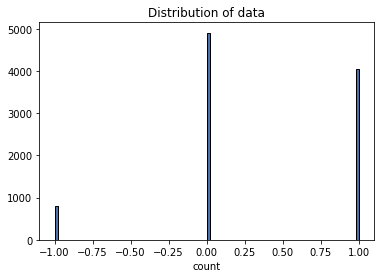

In [68]:
#looking at agreement column
plt.hist(data['label'], bins = 100, edgecolor = 'k')
plt.xlabel('count') 
plt.title('Distribution of data')
plt.show()

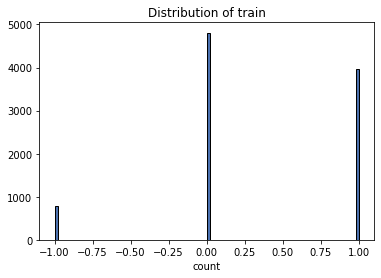

In [69]:
#looking at train data
plt.hist(y_train, bins = 100, edgecolor = 'k')
plt.xlabel('count') 
plt.title('Distribution of train')
plt.show()

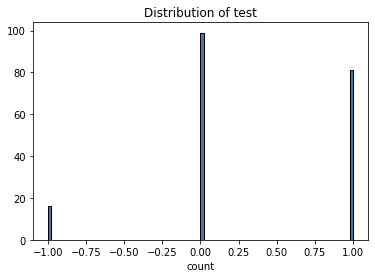

In [70]:
#looking at train data
plt.hist(y_test, bins = 100, edgecolor = 'k')
plt.xlabel('count') 
plt.title('Distribution of test')
plt.show()

In [71]:
 from sklearn.metrics import precision_recall_curve,cohen_kappa_score

In [72]:
print(cohen_kappa_score(y_test,y_pred_svc))

0.5168294301697165


In [73]:
tweet = "vaccines give kids autism"
input = clean_tweets(tweet)
print(svc.predict([input]))

[1.]
